Data is available [here.](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# You may need to restart the kernel after installing and seeing any kind of error. After restarting, try to install it again.
!pip install scikit-learn==0.22.2 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.6 MB/s 


In [29]:
import pandas as pd
import numpy as np
import joblib
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.externals import joblib
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

In [7]:
# Loading data
data = pd.read_csv('/content/drive/MyDrive/ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [10]:
# Data inspection
print('The number of all words:', len(data['Word']))
print('The number of all unique words:', len(data['Word'].unique()))
print('The number of all unique tags:', len(data['Tag'].unique()))
print('The distribution of tags: \n', data['Tag'].value_counts())

The number of all words: 1048575
The number of all unique words: 35178
The number of all unique tags: 17
The distribution of tags: 
 O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64


In [11]:
# Getting data ready
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [12]:
data_fillna = data.fillna(method='ffill', axis=0)
getter = getsentence(data_fillna)
sentences = getter.sentences

In [16]:
print('The number of sentences:', len(sentences),'\n')
print('This is how a sentence will look like:\n', sentences[0])

The number of sentences: 47959 

This is how a sentence will look like:
 [('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [17]:
#Lets find the number of words in the dataset
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

35178


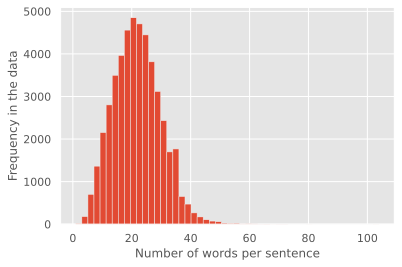

In [21]:
#Lets visualize how the data are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('Number of words per sentence')
plt.ylabel('Frequency in the data')
plt.show()

In [22]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 104


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


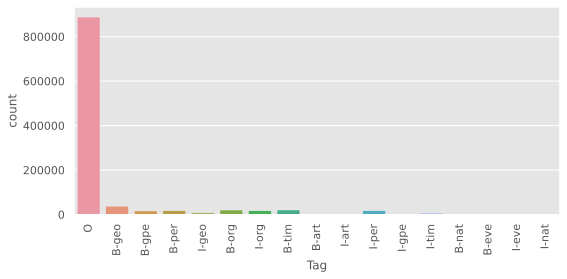

In [23]:
#Words distribution across Tags
plt.figure(figsize=(8, 4))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


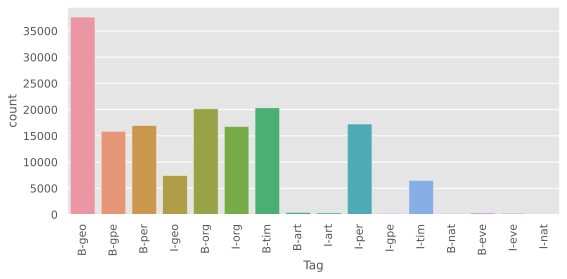

In [24]:
#Words distribution across Tags without O tag
plt.figure(figsize=(8, 4))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


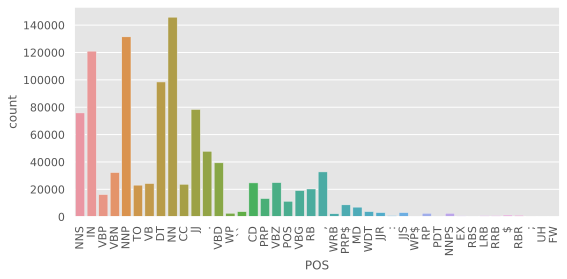

In [25]:
#Words distribution across POS
plt.figure(figsize=(8, 4))
ax = sns.countplot('POS', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [27]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [28]:
#Creating the features and labels set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [30]:
# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [31]:
print('Number of sentences in train:', len(X_train))
print('Number of labels in train:', len(y_train), '\n')
print('Number of sentences in test:', len(X_test))
print('Number of labels in test:', len(y_test))

Number of sentences in train: 43163
Number of labels in train: 43163 

Number of sentences in test: 4796
Number of labels in test: 4796


In [32]:
# Creating the CRF model
crf = CRF(algorithm='lbfgs',
          max_iterations=100,
          all_possible_transitions=False)
crf.fit(X_train, y_train)

/root/.local/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [33]:
# Predict
y_pred = crf.predict(X_test)

In [34]:
#Lets evaluate the mode
report = flat_classification_report(y_pred=y_pred, y_true=y_test)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        46
       B-eve       0.60      0.43      0.50        35
       B-geo       0.85      0.91      0.88      3797
       B-gpe       0.95      0.93      0.94      1592
       B-nat       0.38      0.15      0.21        20
       B-org       0.80      0.68      0.74      2055
       B-per       0.81      0.81      0.81      1668
       B-tim       0.92      0.86      0.89      2033
       I-art       0.00      0.00      0.00        40
       I-eve       0.60      0.38      0.47        39
       I-geo       0.83      0.79      0.81       713
       I-gpe       0.89      0.50      0.64        16
       I-nat       0.00      0.00      0.00         7
       I-org       0.79      0.75      0.77      1699
       I-per       0.81      0.91      0.85      1658
       I-tim       0.79      0.75      0.77       585
           O       0.99      0.99      0.99     88532

    accuracy              

In [ ]:
# Results were not good. We proceed with adding more features to data and use cross validation.

In [68]:
#First we select all the tags that are relevant for us i.e. remove the 'O' tag from the list. 
labels = list(data_fillna['Tag'].unique())
labels_no_O = list(data_fillna['Tag'].unique())
labels_no_O.remove('O')
print('Number of tags in total:', len(labels))
print('Number of tags without tag "O":', len(labels_no_O))

Number of tags in total: 17
Number of tags without tag "O": 16


In [29]:
#Now we will create the Randomized CV search model wherein we will use a modified F1 scorer model considering only the relevant labels
# define fixed parameters and parameters to search
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=5,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/root/.local/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 44.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbb44bdf580>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, l

In [31]:
# Saving the best estimator
joblib.dump(rs.best_estimator_, '/content/drive/MyDrive/rs_bestmodel2.pkl')

['/content/drive/MyDrive/rs_bestmodel2.pkl']

In [32]:
#saving the the whole trained model
joblib.dump(rs, '/content/drive/MyDrive/rs_object2.pkl')

['/content/drive/MyDrive/rs_object2.pkl']

In [76]:
#load the model
model = joblib.load('/content/drive/MyDrive/rs_object2.pkl')

In [77]:
#Lets check the best estimated parameters and CV score
print('Best parameters:', model.best_params_)
print('Best CV score:', model.best_score_)
print('Model size: {:0.2f}M'.format(model.best_estimator_.size_ / 1000000))

Best parameters: {'c1': 0.23742667939482595, 'c2': 0.06895608578120505}
Best CV score: 0.8496491424772602
Model size: 2.64M


In [78]:
#We sort the tags a bit so that they appear in an orderly fashion in the classification report
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0]))
sorted_labels_no_O = sorted(
    labels_no_O,
    key=lambda name: (name[1:], name[0]))

In [79]:
# Check the best estimator on train data
crf = model.best_estimator_
y_pred = crf.predict(X_train)

In [80]:
# Results with considering tag "O"
print(metrics.flat_classification_report(y_train, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           O      0.996     0.997     0.996    799376
       B-art      0.943     0.742     0.830       356
       I-art      0.950     0.805     0.872       257
       B-eve      0.843     0.711     0.771       273
       I-eve      0.840     0.664     0.742       214
       B-geo      0.910     0.951     0.930     33847
       I-geo      0.906     0.920     0.913      6701
       B-gpe      0.983     0.953     0.968     14278
       I-gpe      0.955     0.703     0.810       182
       B-nat      0.872     0.641     0.739       181
       I-nat      0.935     0.659     0.773        44
       B-org      0.911     0.856     0.882     18088
       I-org      0.937     0.937     0.937     15085
       B-per      0.947     0.926     0.936     15322
       I-per      0.938     0.957     0.947     15593
       B-tim      0.959     0.928     0.943     18300
       I-tim      0.924     0.894     0.909      5943

    accuracy              

In [81]:
# Results with NOT considering tag "O"
print(metrics.flat_classification_report(y_train, y_pred, labels=sorted_labels_no_O, digits=3))

              precision    recall  f1-score   support

       B-art      0.943     0.742     0.830       356
       I-art      0.950     0.805     0.872       257
       B-eve      0.843     0.711     0.771       273
       I-eve      0.840     0.664     0.742       214
       B-geo      0.910     0.951     0.930     33847
       I-geo      0.906     0.920     0.913      6701
       B-gpe      0.983     0.953     0.968     14278
       I-gpe      0.955     0.703     0.810       182
       B-nat      0.872     0.641     0.739       181
       I-nat      0.935     0.659     0.773        44
       B-org      0.911     0.856     0.882     18088
       I-org      0.937     0.937     0.937     15085
       B-per      0.947     0.926     0.936     15322
       I-per      0.938     0.957     0.947     15593
       B-tim      0.959     0.928     0.943     18300
       I-tim      0.924     0.894     0.909      5943

   micro avg      0.933     0.927     0.930    144664
   macro avg      0.922   

In [82]:
# Now we predict on test data with the best estimator
y_pred = crf.predict(X_test)

In [83]:
# Results with considering tag "O"
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           O      0.993     0.994     0.993     88532
       B-art      0.214     0.065     0.100        46
       I-art      0.125     0.025     0.042        40
       B-eve      0.536     0.429     0.476        35
       I-eve      0.708     0.436     0.540        39
       B-geo      0.863     0.916     0.889      3797
       I-geo      0.829     0.809     0.819       713
       B-gpe      0.968     0.945     0.956      1592
       I-gpe      1.000     0.500     0.667        16
       B-nat      0.700     0.350     0.467        20
       I-nat      0.800     0.571     0.667         7
       B-org      0.806     0.740     0.772      2055
       I-org      0.813     0.807     0.810      1699
       B-per      0.850     0.827     0.838      1668
       I-per      0.847     0.897     0.872      1658
       B-tim      0.929     0.895     0.912      2033
       I-tim      0.791     0.810     0.801       585

    accuracy              

In [84]:
# Results with NOT considering tag "O"
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels_no_O, digits=3))

              precision    recall  f1-score   support

       B-art      0.214     0.065     0.100        46
       I-art      0.125     0.025     0.042        40
       B-eve      0.536     0.429     0.476        35
       I-eve      0.708     0.436     0.540        39
       B-geo      0.863     0.916     0.889      3797
       I-geo      0.829     0.809     0.819       713
       B-gpe      0.968     0.945     0.956      1592
       I-gpe      1.000     0.500     0.667        16
       B-nat      0.700     0.350     0.467        20
       I-nat      0.800     0.571     0.667         7
       B-org      0.806     0.740     0.772      2055
       I-org      0.813     0.807     0.810      1699
       B-per      0.850     0.827     0.838      1668
       I-per      0.847     0.897     0.872      1658
       B-tim      0.929     0.895     0.912      2033
       I-tim      0.791     0.810     0.801       585

   micro avg      0.860     0.854     0.857     16003
   macro avg      0.736   